# Multifidelity Simulation

We wish to find representative regions of simulation and replace those regions with a statistical model to reduce the computational cost of simulation.

This notebook demonstrates two things: 
1. How do we find phases?
2. How do we determine onwhence we have completed any warm-up associated with the phase?

In [162]:
# Built-in modules
import os
import sys
import time
import statistics
from dataclasses import dataclass

# External modules
import scipy
import numpy as np
import pandas as pd
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from bokeh.palettes import Pastel1
from tqdm import tqdm

# Local modules
from Window import Window
from Mapper import Mapper
import Trace
import PhaseDetector

In [120]:
# C++ phase detector
import sys
import os
sys.path.insert(0, '/nethome/plavin3/sst/spec-utils/libpd/build')
import FastPhaseDetector
import importlib
_ = importlib.reload(FastPhaseDetector)
_ = importlib.reload(Trace)

In [121]:
# Some options

use_notebook_pd = False

In [122]:
# Pretty errors
import stackprinter
stackprinter.set_excepthook(style='lightbg3')

In [123]:
DATA_DIR = 'parrot-traces/polybench-v0.1/'
#DATA_DIR = 'parrot-traces/medium-test/'

In [124]:
TRACES = Trace.TraceList(DATA_DIR, new_ext=True)
TRACES_NORM = Trace.TraceList('parrot-traces/polybench-v0.1-normal/', new_ext=True)

In [101]:
print('Directory:'.ljust(10), DATA_DIR)
print('Files:'.ljust(10), TRACES)

Directory: parrot-traces/polybench-v0.1/
Files:     2mm 3mm adi atax bicg cholesky correlation covariance deriche doitgen durbin fdtd-2d floyd-warshall gemm gemver gesummv gramschmidt heat-3d jacobi-1d jacobi-2d lu ludcmp mvt nussinov seidel-2d symm syr2k syrk trisolv trmm


In [133]:
NAMES = set([t.name for t in TRACES])
NAMES_NORM = set([t.name for t in TRACES_NORM])

if NAMES != NAMES_NORM:
    raise Exception('The benchmarks found in the two data dirs do not match')

In [134]:
%%time
TRACES.load() # Load the traces into memory. Optional. Skip if all traces can't fit into memory at once
TRACES_NORM.load() # Load the traces into memory. Optional. Skip if all traces can't fit into memory at once

CPU times: user 13min 53s, sys: 2min, total: 15min 54s
Wall time: 16min 16s


In [104]:
#%%time
#pd = PhaseDetector(self, interval_len=10000, stable_min=4, threshold=.5, bits_log2 = 10, drop_bits = 3, binary_filename=None):

if (use_notebook_pd):
    phases = {}
    for t in tqdm(TRACES):
        addrs = np.uint64(t.data['ip'])
        phases[t.name] = FastPhaseDetector.run_pd(addrs, 0.5, 10000, 10, 4)

In [173]:
@jit
def get_phase_changes(phases):
    pc = []
    for i in range(len(phases)-1):
        if phases[i] != phases[i+1]:
            pc.append(i)
    return pc

def reformat_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(direction='in')
    
@jit
def get_phase_changes(arr, interval_len):
    marker = 0
    #changes = {0:arr[0]}
    intervals = []
    for i in range(len(arr)-1):
        if arr[i] != arr[i+1]:
            intervals.append([marker, i//interval_len, arr[i]])
            marker = i//interval_len
    intervals.append([marker, i//interval_len, arr[-1]])
    return intervals    

def latency_phase_plot(ax, t, param, t2=None):

    # Unpack parameter object
    interval_len = param.interval_len
    
    # Get latency data
    df = t.load(persist=True)
    series = df['latency_nano']

    # We will average over intervals. Calculate how many intervals of size interval_len there are
    nintervals = len(series)//interval_len
    peri = [np.mean(series[i*interval_len : (i+1)*interval_len]) for i in range(nintervals)]
    
    # Plot
    ax.plot(peri, color='black', markersize=1)
    
    # Second plot
    if t2 is not None:
        df2 = t2.load(persist=True)
        series2 = df2['latency_nano']
        nintervals2 = len(series2)//interval_len
        peri2 = [np.mean(series2[i*interval_len : (i+1)*interval_len]) for i in range(nintervals2)]
        ax.plot(peri2, color='grey', markersize=2)
    
    # Add benchmark name
    ax.text(nintervals//2, 15, t.name, ha='center')
    
    # Formatting
    reformat_ax(ax)
    ax.set_xticks([nintervals//2, nintervals])
    
    # Add in automated PD lines
    if (use_notebook_pd):
        pc = phases[t.name]
        pc[len(series)] = -1 # add in a fake final phase end 
    
    #last_phase_start = 0
    #last_phase_id = -1
    #for phase_start, phase_id in pc.items():
    #    ax.axvline(phase_start//interval_len, color='red')
    #    if phase_start != 0 and last_phase_id != -1:
    #        phase_len = (phase_start - last_phase_start) / 2
    #        phase_center = (last_phase_start + phase_len)/interval_len
    #        ax.text(phase_center, 13, str(last_phase_id), color='red')
    #    last_phase_start = phase_start
    #    last_phase_id = phase_id
    
    # Draw red lines for the phases that came from the notebook phase detector
    # The notebook pd is the same as the one used in the program. Good sanity check.
    if (use_notebook_pd):
        for i in range(len(pc.keys())):
            phase_start = list(pc.keys())[i]
            phase_id = pc[phase_start]
            #ax.axvline(phase_start//interval_len, color='red')
            ax.vlines(phase_start//interval_len, 0, 15, color='red')
        
            if i != len(pc.keys())-1 and phase_id != -1:
                center = (phase_start + (list(pc.keys())[i+1] - phase_start)/2)/interval_len
                ax.text(center, 13, str(phase_id), color='red')
    
    if param.skip_phases:
        return
    
    # Add background patches for each interval
    
    seen = []
    color = Pastel1[9]
    intervals = get_phase_changes(np.array(df['phase']), interval_len)
    stable_region_ret = {}
    for start, end, phase in intervals:
        rectangle = matplotlib.patches.Rectangle((start, 0), end - start, 15, facecolor=color[phase%len(color)])
        ax.add_patch(rectangle)
        
        # Draw red lines for the representative regions (RRs).
        # The RRs are in the <trace>.stable dictionary
        # They first number is the offset (in num instructions) from the start of the phase
        # The second number is the size (in num instructions) of the RR
        if (phase != -1 and phase not in seen):
            seen.append(phase)
            stable_row = t.stable[t.stable['phase'] == phase]
            if (np.int(stable_row['stable_size']) == 0):
                continue
            stable_start = np.int(stable_row['stable_start'])/interval_len + start
            stable_end = np.int(stable_row['stable_size'])/interval_len + stable_start
            #print(f'phase: {phase}, start: {stable_start}, end: {stable_end}, ({start}, {end})')
            ax.vlines(stable_start, 0, 15, color='red')
            ax.vlines(stable_end, 0, 15, color='red')
            ax.text(stable_start+2, 0.5, str(phase), color='red')


In [174]:
def plot_all(traces, plotter, param, suptitle=None, filename=None, traces2=None):
    mapper = Mapper(len(traces)) 
    fig = mapper.fig
    accum = {}
    
    for i, t in enumerate(traces):
        t2 = None
        if traces2 is not None:
            t2 = traces2.find(t.name)
        accum[t.name] = plotter(mapper[i], t, param, t2)
        
    fig.set_size_inches((5*mapper.smallest_sq, 2*mapper.smallest_sq))
    fig.patch.set_facecolor('white')
    if suptitle is not None:
        fig.suptitle(suptitle)
    if filename is not None:
        fig.savefig(filename)
    plt.show()
    
    return accum

In [175]:
@dataclass(frozen=True)
class Param:
    interval_len: int = 100_000
    two_plots: bool = False
    skip_phases: bool = False

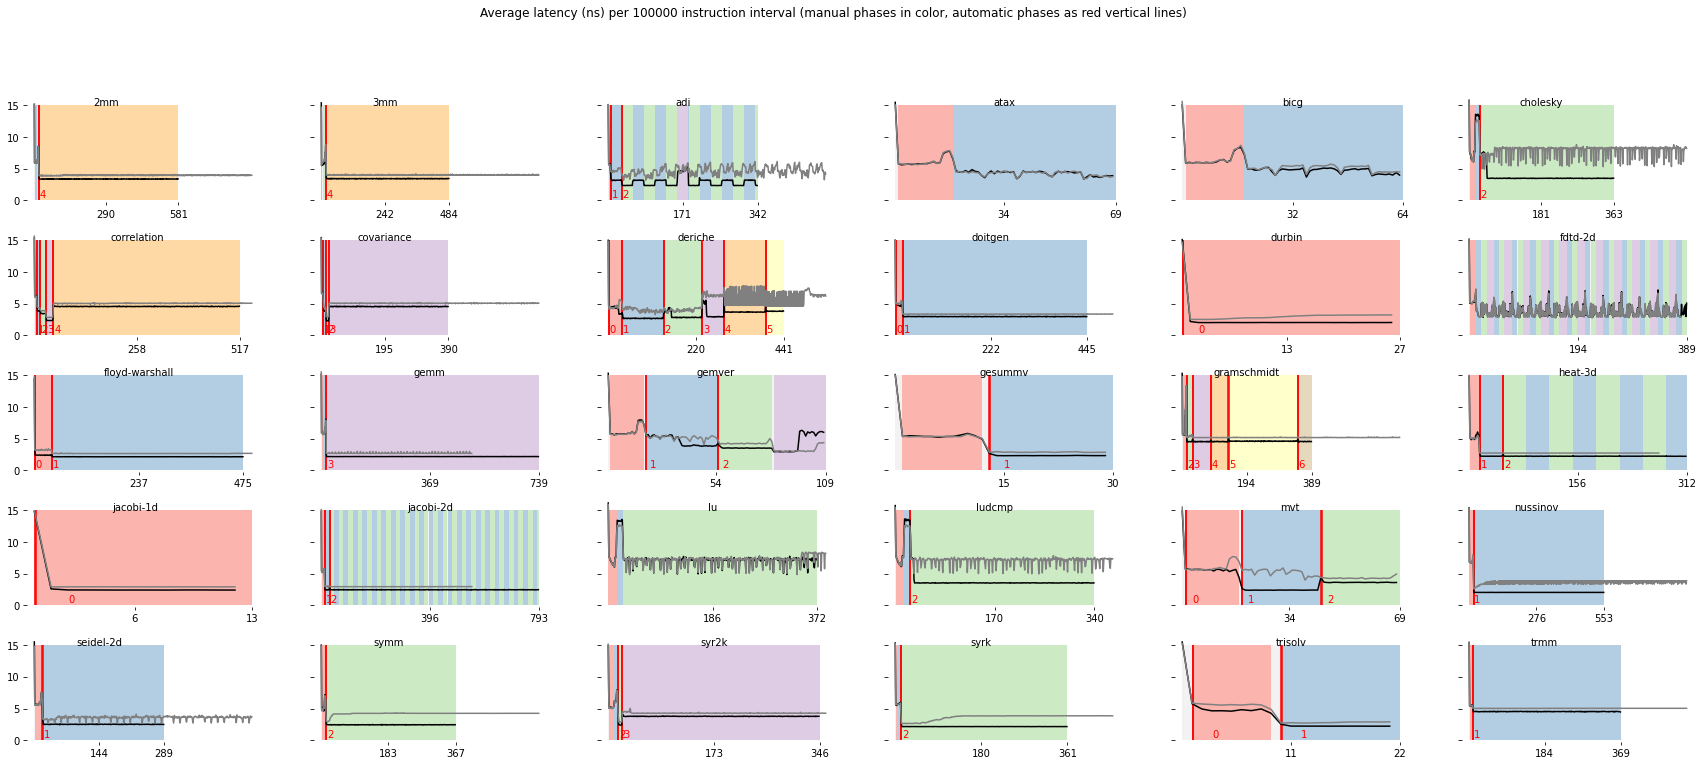

In [177]:
#interval_len = 1000
title = f'Average latency (ns) per {interval_len} instruction interval (manual phases in color, automatic phases as red vertical lines)'
_ = plot_all(TRACES, latency_phase_plot, Param(), suptitle=title, traces2=TRACES_NORM, filename='mf-vs-normal.png')

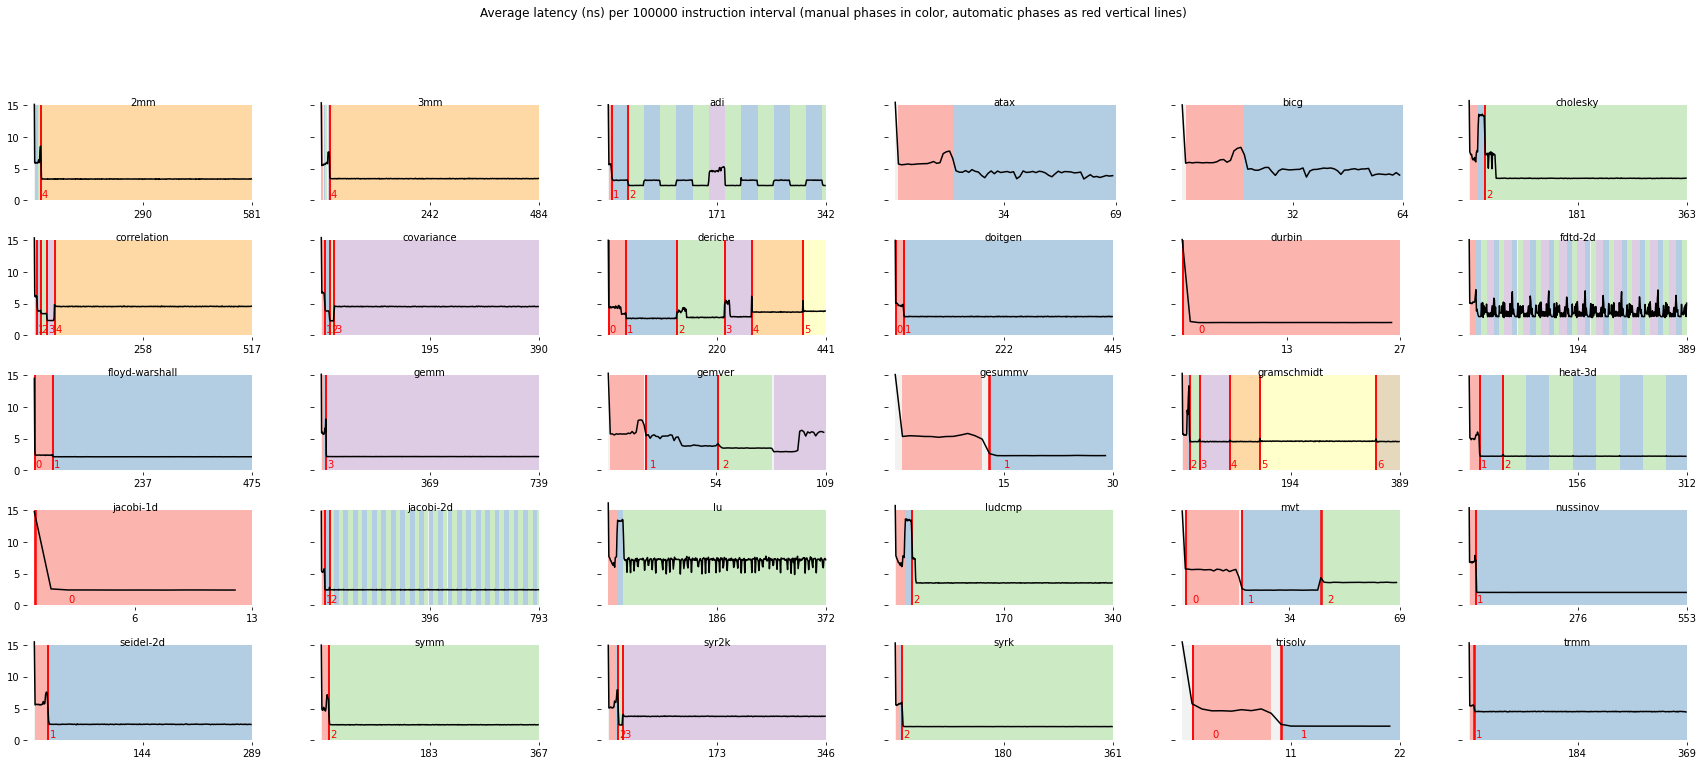

In [155]:
_ = plot_all(TRACES, latency_phase_plot, Param(), suptitle=title)

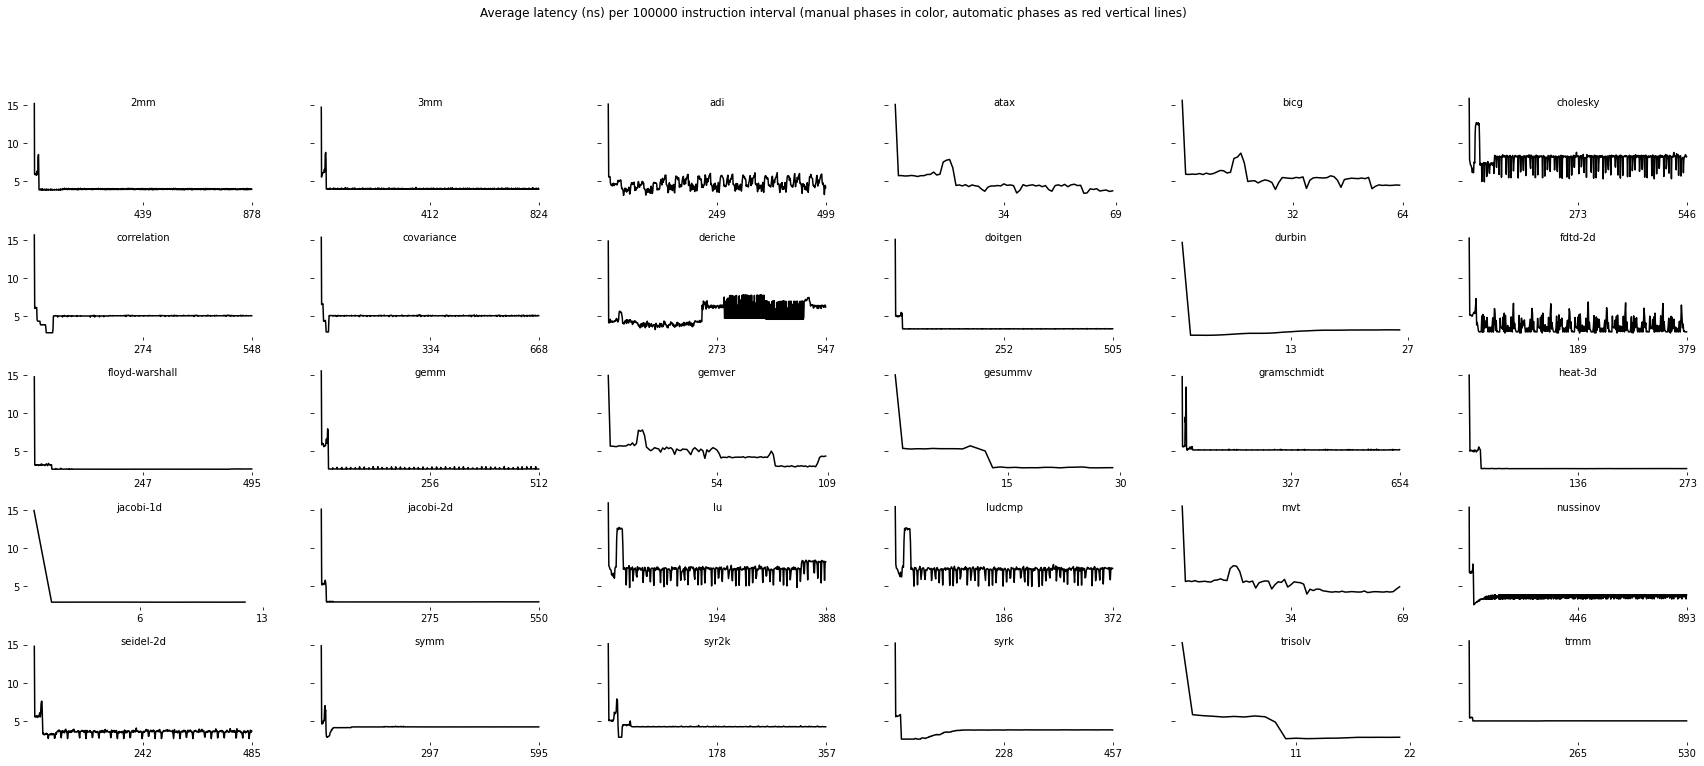

In [165]:
_ = plot_all(TRACES_NORM, latency_phase_plot, Param(skip_phases=True), suptitle=title)

# More plots

- [x] Collect traces from the real runs
- [ ] Plot the real data on top of our data to see how the latency changes
- [ ] Collect 5 runs each of the mf data
- [ ] Collect 5 runs each of the normal data
- [ ] Display % of time per phase
- [ ] Accuracy of MF vs real 
- [ ] There appears to be a bug where you might end up training on data from the last phase. 


## More Evaluation

1. For the polybench benchmarks, determine if this method has an acceptable accuracy for the same system configuration that we collected the data on. 
2. Test other cache parameters
    - The methodology may need to be added to the simulator for it to work with other system configurations
    - For a full-evaluation, we may need to 
3. Try multi-threaded runs
    - The L2 cache will still be shared
    - Note to self: I need to make sure multiple threads don't send the same phase message

# Building the Parrot

- [x] Create region file
- [x] Add "region-file" parameter to Parrot ('file-name.txt:benchmark-name')
- [x] Parse filename and benchmarkname
- [x] Read in data for benchmark from file
- [ ] Subset the workset file (or dont?)
- [x] Sanity check - make sure that the correct phase is executing for each phase specified by the file
- [x] Add a vector to store the representative region (RR)
- [x] Collect the RR
- [x] Implement sampling from the RR
- [ ] Check that everything works for multiple phases
- [ ] more error checking on which pahse we are in
- [ ] Script to compare runtime with and without Parroting (make sure tracing is disabled - probably add this comnand line option too)
- [ ] IMPORTANT: fix time conversion on selfLink->send
- [ ] Create struct in Parrot.h to hold on to phase information. Then we only need one map. Also make sure the default value for the map is the -1 phase, or create a special placeholder in the map for the -1 phase
- [ ] Try linear access instead of random lol
- [ ] Add IPC output? Or find where you left it


In [130]:
np.max(np.array(TRACES.traces[5].data['phase']))

-1

# FtPjRG Testing

We will run FtPjRG on the full traces (not per-phase) and examine the debug output so we can compare with C++. 

In [145]:
t = TRACES[6]
print(t)
params = FTPJ(proj_dist=5, window_start=500, summarize=500, p_j=4, proj_delta=2, debug=True)
ret = ftPjRG2(t, params)
print(ret)

correlation
First 10 elements:  [38.242 13.616 14.086 19.036 22.786  6.024 11.134 12.5    5.516  9.782]
Phase 1! (Iteration 1)
  f-test: [0,500] -> f_val = 5.493029048887562, f_pv = 1.1102230246251565e-16
Phase 1 - grow window
Phase 1 - window not too big
Phase 1! (Iteration 2)
  f-test: [500,501] -> f_val = 1.1749011368496098, f_pv = 0.03591309979886148
Phase 1 - grow window
Phase 1 - window not too big
Phase 1! (Iteration 3)
  f-test: [1001,502] -> f_val = 54.10202931285833, f_pv = 1.1102230246251565e-16
Phase 1 - grow window
Phase 1 - window not too big
Phase 1! (Iteration 4)
  f-test: [1503,503] -> f_val = 2.893606814887117, f_pv = 1.1102230246251565e-16
Phase 1 - grow window
Phase 1 - window not too big
Phase 1! (Iteration 5)
  f-test: [2006,504] -> f_val = 0.5426976813453338, f_pv = 0.9999999999947078
Phase 1 - go to Phase 2
Phase 2! (Iteration 6)
  t-test: [2006,504] -> t_val = -0.2947181234394764, t_pv = 0.7682700228329742
Phase 2 - passed t-test, go to Phase 3
Phase 3! (Iterat

In [160]:
TRACES_NORM[0].data['phase']

0          -1
1          -1
2          -1
3          -1
4          -1
           ..
87872270    4
87872271    4
87872272    4
87872273    4
87872274    4
Name: phase, Length: 87872275, dtype: int64

In [258]:
%%time

def get_all_of_phase(phase_changes, phase_id):
    ret = []
    for pc in phase_changes:
        if pc[2] == phase_id:
            ret.append(pc)
    return ret

class SegmentedTrace:
    def __init__(self, trace):
        self.trace = trace
        if self.trace.stable is not None:
            self.all_phases = np.array(self.trace.stable['phase'])
            self.stable_phases = np.array(self.trace.stable['phase'][self.trace.stable['stable_size']!=0])
        else:
            self.all_phases = list(set(list(self.trace.data['phase'])))
            self.all_phases = sorted(self.all_phases)[1:]
        self.phase_changes = get_phase_changes(np.array(self.trace.data['phase']), 1)
        
        self.phase_extents = {} # {phase_id:[[start,stop],[start,stop]...],phase_id:[],...}
        self.rr = {} # {phase_id:[start,stop],phase_id:[start,stop],...}
        self.mean_per_rr = {}
        self.mean_per_phase = {}
        for ph in self.all_phases:
            self.phase_extents[ph] = []
            tmp = np.array([],dtype=np.uint64)
            for pc in get_all_of_phase(self.phase_changes, ph):
                self.phase_extents[ph].append([pc[0], pc[1]])
                #print(len(np.array(self.trace.data['latency_nano'])), len(np.array(self.trace.data['latency_nano'])[pc[0]:pc[1]]))
                #tmp = np.append(tmp)
                tmp = np.append(tmp,np.array(self.trace.data['latency_nano'])[pc[0]:pc[1]])
            self.mean_per_phase[ph] = np.mean(tmp)
            
        if self.trace.stable is not None:
            for ph in self.stable_phases:
                phase_start = self.phase_extents[ph][0][0]
                region_start = int(self.trace.stable['stable_start'][self.trace.stable['phase']==ph])
                region_size = int(self.trace.stable['stable_size'][self.trace.stable['phase']==ph])
                start = phase_start+region_start
                end = start+region_size
                self.rr[ph] = [start, end]
                self.mean_per_rr[ph] = np.mean(np.array(self.trace.data['latency_nano'])[start:end])

        #for ph in self.stable_phases:

SEG = {}
SEG_NORM = {}
for t in TRACES:
    SEG[t.name] = SegmentedTrace(t)
for t in TRACES_NORM:
    SEG_NORM[t.name] = SegmentedTrace(t)

CPU times: user 2min 41s, sys: 45.2 s, total: 3min 26s
Wall time: 3min 27s


In [289]:
def per_phase_bar(ax, mf, norm):
    bar1 = []
    bar2 = []
    width=0.25
    x = np.arange(len(mf.stable_phases))
    for ph in mf.stable_phases:
        bar1.append(mf.mean_per_rr[ph])
        bar2.append(norm.mean_per_phase[ph])
    ax.bar(x-(width/2), bar1, width, color='white', label='Normal', edgecolor='black')
    ax.bar(x+(width/2), bar2, width, color='lightgrey', label='Multidelity', edgecolor='black')
        
        
#for name in SEG:
 #   print(name)
#    per_phase_bar(None, SEG[name], SEG_NORM[name])
#per_phase_bar(None, SEG['2mm'], SEG_NORM['2mm'])

In [291]:
bench_with_stable = [name for name in SEG if len(SEG[name].stable_phases) > 0]
print(bench_with_stable)
n_traces = len(bench_with_stable)

fig, axs = plt.subplots(nrows=1, ncols=n_traces)
for name,ax in zip(bench_with_stable, axs):
    per_phase_bar(ax, SEG[name], SEG_NORM[name])
    
fig.set_size_inches((n_traces,1))


TypeError: object of type 'int' has no len()